In [45]:
#сделать трейлинг стоп по проценту от цены
# сделать время сколько в сделке провел
# Сделать ATR стоплосс и скользяк

In [46]:
import yfinance as yf
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

import pprint

import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

In [47]:
from s&p500_dash import


[*********************100%***********************]  1 of 1 completed


In [ ]:
ticker = "vxx"
# data = yf.download(ticker, start="2019-12-10", interval = "1H")

data = yf.download("vxx", start="2019-12-10", interval = "1H")

In [48]:

data = round(data, 2)
data = data.rename({'Adj Close': 'close'}, axis='columns')
data['rolMax'] = data.High.rolling(window =95).max()
data['rolMin'] = data.Low.rolling(window =70).min()
data['avPch'] = (data.rolMax + data.rolMin)/2
data['returns'] = data.close.pct_change() * 100
data = data.dropna(axis=0)
data['atr'] = data.returns.rolling(window =24).mean()
data = data.dropna(axis=0)

data

,Open,High,Low,Close,close,Volume,rolMax,rolMin,avPch,returns,atr
2020-01-06 10:30:00-05:00,61.62,61.88,60.88,61.36,61.36,3449906,65.94,58.00,61.970,-0.454250,-0.087470
2020-01-06 11:30:00-05:00,61.20,61.56,61.06,61.44,61.44,2348885,64.24,58.00,61.120,0.130378,-0.108594
2020-01-06 12:30:00-05:00,61.47,61.47,60.80,60.86,60.86,2747398,64.24,58.00,61.120,-0.944010,-0.169038
2020-01-06 13:30:00-05:00,60.88,60.96,60.40,60.52,60.52,2424788,64.24,58.00,61.120,-0.558659,-0.179188
2020-01-06 14:30:00-05:00,60.48,60.76,60.40,60.56,60.56,2306779,64.24,58.00,61.120,0.066094,-0.168533
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-03 11:30:00-05:00,27.14,28.30,27.06,27.98,27.98,15466182,28.30,20.22,24.260,3.095063,1.023353
2021-12-03 12:30:00-05:00,27.97,28.60,27.67,28.49,28.49,13313172,28.60,20.22,24.410,1.822731,0.872300
2021-12-03 13:30:00-05:00,28.49,30.06,28.44,29.58,29.58,17722991,30.06,20.22,25.140,3.825904,0.821778
2021-12-03 14:30:00-05:00,29.57,30.15,28.40,28.71,28.71,23840064,30.15,20.22,25.185,-2.941176,0.628091


In [49]:
# переделать цикл с ценой а не с состоянием , что бы можно было разные условия выхода делать
#Получить цену Первого и последнего True и False

positionDict = {}
posList = []
counter = 0

openPriceNow = 0.0

sidePos = 'short'

slInPerc = 33
slInPerc = slInPerc/100 + 1 # для шорта
tpInPerc = 21
tpInPerc = (100 - tpInPerc)/100 # для шорта

for price in data['close']:
    # print([data.loc[data.index[counter], 'close'], data.loc[data.index[counter-1], 'avPch' ]])
    # print([data.loc[data.index[counter-1], 'close'], data.loc[data.index[counter-1], 'avPch' ]])
    if counter > 0:
        conditionForOpenPos = price < data.loc[data.index[counter], 'avPch'] and data.loc[data.index[counter-1], 'close'] > data.loc[data.index[counter-1], 'avPch'] 
        conditionForClosePos = ((data.loc[data.index[counter], 'close'] > openPriceNow * slInPerc) or (data.loc[data.index[counter], 'close'] < openPriceNow * tpInPerc) ) and openPriceNow > 0 
        
        # conditionForOpenPos = price  == False and data.loc[data.index[counter - 1], 'CloseUpperPch'] == True  # в этом случае открываем позицию на перво клозе ниже средней линии и закрываем на первом клозе выше средней линии а
        # conditionForClosePos = price  == True and data.loc[data.index[counter - 1], 'CloseUpperPch'] == False # проверяем

        if conditionForOpenPos and openPriceNow == 0.0 :
            # print('111')
            positionDict['openPosTime'] = data.index[counter]
            positionDict['openPosPrice'] = data.loc[data.index[counter], 'close']
            openPriceNow = data.loc[data.index[counter], 'close']   
        # print(data.loc[data.index[counter], 'close'])
        # print(openPoPriceNow * 1.001)
        elif conditionForClosePos :
            # print('22222')
            positionDict['closePosTime'] = data.index[counter]
            positionDict['closePosPrice'] = data.loc[data.index[counter], 'close']

            posList.append(positionDict)
            positionDict = {}  
            openPriceNow = 0.0
           
    counter += 1
# posList.pop(0)
    
# print(len(posList))
# for i in posList:
#     pprint.pprint(i)

# plt.figure(figsize=(50, 25))
# plt.plot(data.index, data['close'])
# plt.plot(data.index, data.rolMax)
# plt.plot(data.index, data.rolMin)
# plt.plot(data.index, data.avPch)
# # plt.plot(data.index, data.atr_avPch)

# for i in posList:
#     plt.text(i['openPosTime'], i['openPosPrice'], ".", fontsize=60)

# for i in posList:
#     plt.text(i['closePosTime'], i['closePosPrice'], ".", fontsize=60, c='red')

# plt.grid()
# # plt.xlabel(symbolId, fontsize=18)
# # plt.ylabel('Price', fontsize=18)

# plt.show()

In [50]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y= data.close, name='vxx'))
fig.add_trace(go.Scatter(x=data.index, y=data.avPch, name='avPc'))
fig.add_trace(go.Scatter(x=data.index, y=data.avPch*0.97, name='avPcustom'))
fig.add_trace(go.Scatter(x=data.index, y=data.rolMax, name='rolMax'))
fig.add_trace(go.Scatter(x=data.index, y=data.rolMin, name='rolMin'))
# fig.add_trace(go.Scatter(x=data.index, y=data.avPch + (data.atr*7), name='atr_avPch', visible='legendonly'))
# fig.update_xaxes(rangeslider_visible=True)

for i in posList:
    fig.add_annotation(x=i['openPosTime'], y=i['openPosPrice'],
                text="o",
                showarrow=True,
                arrowhead=1)

for i in posList:
    fig.add_annotation(x=i['closePosTime'], y=i['closePosPrice'],
                text="c",
                showarrow=True,
                arrowhead=1)
fig.update_layout(
    autosize=False,
    width=2500,
    height=1300,
    margin=dict(
        l=10,
        r=10,
        b=20,
        t=20,
        pad=1
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

In [51]:
# Посчитать прибыль убыток для каждой позиции в долларах и в процентах и добавить в словарь posList
if sidePos == 'long':
    for posDict in posList:
        posDict['profitInCash'] = round(posDict['closePosPrice'] - posDict['openPosPrice'], 2)
        posDict['profitInPerc'] = round((posDict['closePosPrice'] - posDict['openPosPrice']) / posDict['openPosPrice'] * 100, 2)
if sidePos == 'short':
    for posDict in posList:
        posDict['profitInCash'] = round(-(posDict['closePosPrice'] - posDict['openPosPrice']), 2)
        posDict['profitInPerc'] = round(-((posDict['closePosPrice'] - posDict['openPosPrice']) / posDict['openPosPrice'] * 100), 2)

# for i in posList[:3]:
#     pprint.pprint(i)

In [52]:
# Посчитать DD каждой позиции
# взять цену входа и проверять каждый минимум бара потом если он меньше цены входа, то его добавляем или просто выбираем минимальный минимум из этого диапазона 
if sidePos == 'long':
    for i in range(len(posList)):
        farestPriceDD = data[posList[i]['openPosTime']:posList[i]['closePosTime']].Low.min()
        posList[i]['maxPosDDinPerc'] = round((farestPriceDD - posList[i]['openPosPrice']) / posList[i]['openPosPrice'] * 100, 2)
if sidePos == 'short':
    for i in range(len(posList)):
        farestPriceDD = data[posList[i]['openPosTime']:posList[i]['closePosTime']].High.max()
        posList[i]['maxPosDDinPerc'] = round((posList[i]['openPosPrice'] -farestPriceDD) / posList[i]['openPosPrice'] * 100, 2)

# for i in posList[:3]:
#     pprint.pprint(i)


In [53]:
# Посчитать максимальный профит по позиции который был
for i in range(len(posList)):
    potentialUnrealisedProfitPerc = data[posList[i]['openPosTime']:posList[i]['closePosTime']].High.max()

    posList[i]['potentialUnrealisedProfit'] = (potentialUnrealisedProfitPerc - posList[i]['openPosPrice']) / posList[i]['openPosPrice'] * 100
    posList[i]['potentialUnrealisedProfit'] = round(posList[i]['potentialUnrealisedProfit'], 2)

# for i in posList[:3]:
#     pprint.pprint(i)


In [54]:
# Посчитать время проведенное в позиции
for position in posList:
    position['timeInPos'] = position['closePosTime'] - position['openPosTime']

# for i in posList[:3]:
#     pprint.pprint(i)


124.46


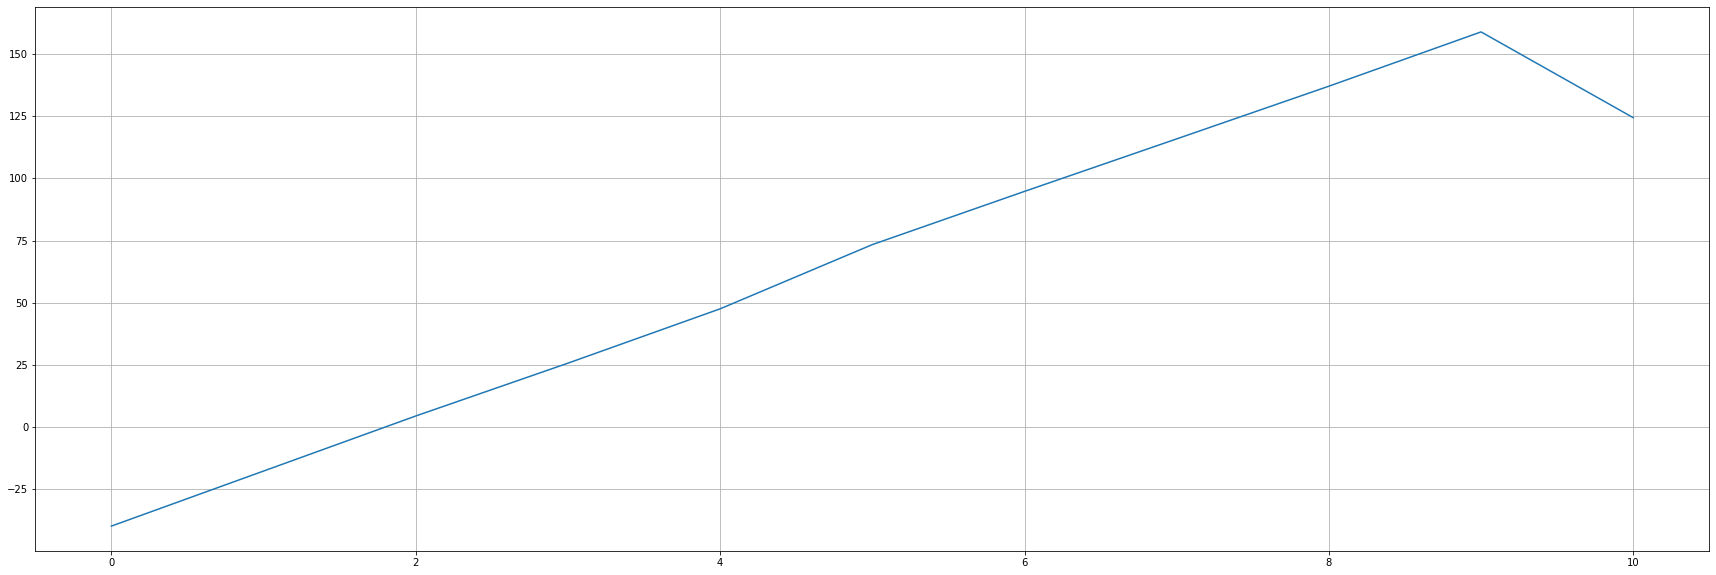

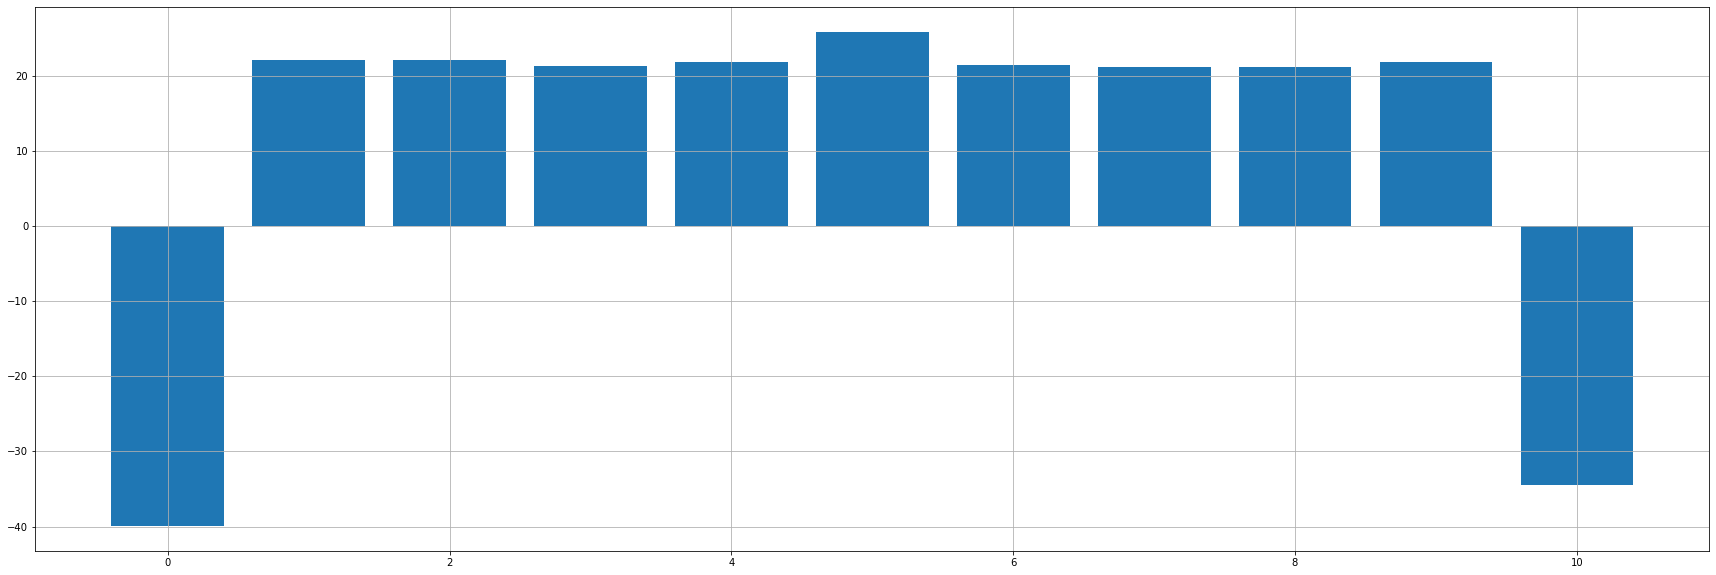

In [55]:
#Посчитать сумму всех позиций в процентах
totalProfit = []
positionsDD = []
for posDict in posList:
    totalProfit.append(posDict['profitInPerc'])
    positionsDD.append(posDict['maxPosDDinPerc'])
profit = sum(totalProfit)
print(round(profit, 2))

# Получить скользящий профит и нанести на график в процентах
plt.figure(figsize=(30, 10))
# totalProfit.pop(4) # удалил выброс один сильный результат
plt.plot(range(len(totalProfit)), np.cumsum(totalProfit))
plt.grid()
plt.show()

plt.figure(figsize=(30, 10))

plt.bar(range(len(totalProfit)), totalProfit)
# plt.bar(range(len(positionsDD)), positionsDD, alpha=0.6)
plt.grid()
plt.show()




In [56]:
def lossInPerc(portf, loss):
    count = 0
    while portf <= 1000:
        portf= portf + (portf * (loss/100))
        count += 1
        print(portf)
    print(count)    

lossInPerc(500, 21 )

605.0
732.05
885.7805
1071.7944049999999
4


In [57]:
def P1_win_prob_weighted_coin_game(num_games, prob_heads=.5): 
    player_one_wins = 0 
    for n in range(0,num_games): 
        num_flips = 0 
        win = 0
        while win == 0: 
            turn = np.random.uniform(0,1) 
            num_flips += 1 
            if turn <= prob_heads: 
                if num_flips % 2 != 0: 
                    player_one_wins += 1 
            win += 1 
    return float(player_one_wins)/float(num_games)